In [822]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from time import time

In [823]:
df_USlist = pd.read_csv("output.csv", index_col="priority_date", parse_dates=True, low_memory=False)

df_USlist.id = df_USlist.id.replace("US-", "", regex=True)
df_USlist.id = df_USlist.id.replace("-A1", "", regex=True)
df_USlist.id = df_USlist.id.replace("-B1", "", regex=True)
df_USlist.id = df_USlist.id.replace("-B2", "", regex=True)
df_USlist.id = pd.to_numeric(df_USlist.id, errors='coerce', downcast='integer')
print(df_USlist.head(10))

df_UKlist = pd.read_csv("query_absDesc_Espace.csv", low_memory=False)
df_UKlist.familyNumber = pd.to_numeric(df_UKlist.familyNumber, errors='coerce', downcast='integer')
print(df_UKlist.head())

                         id  cite_number
priority_date                           
08/01/2017     2.023186e+09         56.0
08/01/2017     1.110705e+07         56.0
08/01/2017     1.157429e+07         56.0
08/01/2017     2.020027e+09         56.0
08/01/2017     2.021074e+09         56.0
07/08/2018     2.021174e+09         13.0
28/08/2020     2.022068e+09          2.0
30/03/2018     2.021082e+09         36.0
28/08/2020     1.135474e+07          2.0
28/02/2019     2.020279e+09          9.0
   filingDate  familyNumber                                            company
0  10/04/2019      72749305  AKIVA CAPITAL HOLDINGS LLC [US] \nAKIVA CAPITA...
1  23/02/2016      58191502                           NCHAIN HOLDINGS LTD [AG]
2  29/04/2016      56234104                           NCHAIN HOLDINGS LTD [AG]
3  27/09/2020      80624746                                           IBM [US]
4  23/02/2016      58231665                           NCHAIN HOLDINGS LTD [AG]


In [824]:
# Convert the index to datetime format (assuming 'priority_date' is the index)
df_USlist.index = pd.to_datetime(df_USlist.index, format="%d/%m/%Y")

# Filter rows with 'priority_date' from 2010 to 2022
mask = (df_USlist.index.year > 2009) & (df_USlist.index.year <= 2022)
df_USfiltered = df_USlist[mask].copy()

print(len(df_USfiltered))
print(len(df_USfiltered.drop_duplicates(subset=["id"])))

df_USpatents = df_USfiltered.drop_duplicates(subset=["id"])


13412
13398


In [825]:
# Assuming 'filingDate' column contains dates in 'dd/mm/yyyy' format
df_UKlist['filingDate'] = pd.to_datetime(df_UKlist['filingDate'], format="%d/%m/%Y")

# Filter rows with 'filingDate' from 2010 to 2022
mask = (df_UKlist['filingDate'].dt.year > 2009) & (df_UKlist['filingDate'].dt.year <= 2022)
df_UKfiltered = df_UKlist[mask].copy()  # Make a copy to avoid the SettingWithCopyWarning

print(len(df_UKfiltered))
print(len(df_UKfiltered.drop_duplicates(subset=["familyNumber"])))

df_UKpatents = df_UKfiltered.drop_duplicates(subset=["familyNumber"])


753
753


In [826]:


# Extract month and year in the desired format

###For US Model
# Extract month and year in the desired format ('01/' at the beginning)
df_USpatents_m = df_USpatents.assign(filingMonthYear='01/' + df_USpatents.index.strftime('%m/%Y'))
us_patents_per_month_m = df_USpatents_m.groupby('filingMonthYear').size().reset_index(name='number_of_patents')
us_patents_per_month_m['number_of_citations'] = df_USpatents_m.groupby('filingMonthYear')['cite_number'].sum().reset_index(name='number_of_citations')['number_of_citations']
# Calculate percentage increase in patents for each month
us_patents_per_month_m['percentage_increase'] = us_patents_per_month_m['number_of_patents'].pct_change() * 100

# Sort by year and month
us_patents_per_month_m['filingYear'] = pd.to_datetime(us_patents_per_month_m['filingMonthYear']).dt.year
us_patents_per_month_m['filingMonth'] = pd.to_datetime(us_patents_per_month_m['filingMonthYear']).dt.month
us_patents_per_month_m = us_patents_per_month_m.sort_values(by=['filingYear', 'filingMonth'])

# Create the final DataFrame
us_patents_data = {
    'filingMonthYear': us_patents_per_month_m['filingMonthYear'],
    'number_of_patents': us_patents_per_month_m['number_of_patents'],
    'percentage_increase': us_patents_per_month_m['percentage_increase'],
    'number_of_citations': us_patents_per_month_m['number_of_citations']
}
us_patents_per_month_df_m = pd.DataFrame(us_patents_data)

############


df_USpatents['filingMonthYear'] = df_USpatents.index.strftime('%m/%Y')

# Group by month and year and count the number of patents
us_patents_per_month = df_USpatents.groupby('filingMonthYear').size().reset_index(name='number_of_patents')

# Sum of citations per month and year
us_patents_per_month['number_of_citations'] = df_USpatents.groupby('filingMonthYear')['cite_number'].sum().reset_index(name='number_of_citations')['number_of_citations']



# Calculate percentage increase in patents for each month
us_patents_per_month['percentage_increase'] = us_patents_per_month['number_of_patents'].pct_change() * 100

# Sort by year and month
us_patents_per_month['filingYear'] = pd.to_datetime(us_patents_per_month['filingMonthYear']).dt.year
us_patents_per_month['filingMonth'] = pd.to_datetime(us_patents_per_month['filingMonthYear']).dt.month
us_patents_per_month = us_patents_per_month.sort_values(by=['filingYear', 'filingMonth'])

# Create the final DataFrame
us_patents_data = {
    'filingMonthYear': us_patents_per_month['filingMonthYear'],
    'number_of_patents': us_patents_per_month['number_of_patents'],
    'percentage_increase': us_patents_per_month['percentage_increase'],
    'number_of_citations': us_patents_per_month['number_of_citations']
}
us_patents_per_month_df = pd.DataFrame(us_patents_data)

print(us_patents_per_month_df)

    filingMonthYear  number_of_patents  percentage_increase  \
11          02/2010                  1           -97.959184   
36          04/2010                  2           100.000000   
61          06/2010                  5            25.000000   
74          07/2010                  4           -20.000000   
87          08/2010                  1           -66.666667   
..              ...                ...                  ...   
73          06/2022                  5           -95.614035   
86          07/2022                  3           -96.000000   
110         09/2022                  2           -97.894737   
121         10/2022                  1           -99.107143   
145         12/2022                  2           -98.290598   

     number_of_citations  
11                   9.0  
36                  12.0  
61                 283.0  
74                  31.0  
87                   6.0  
..                   ...  
73                   0.0  
86                   0.0  


C:\Users\Akande\AppData\Local\Temp\ipykernel_13832\3521922936.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_USpatents['filingMonthYear'] = df_USpatents.index.strftime('%m/%Y')
C:\Users\Akande\AppData\Local\Temp\ipykernel_13832\3521922936.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_patents_per_month['filingYear'] = pd.to_datetime(us_patents_per_month['filingMonthYear']).dt.year
C:\Users\Akande\AppData\Local\Temp\ipykernel_13832\3521922936.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and

In [827]:

# Assuming you have already loaded the 'df_UKpatents' DataFrame


# Extract month and year in the desired format
df_UKpatents['filingMonthYear'] = pd.to_datetime(df_UKpatents['filingDate']).dt.strftime('%m/%Y')

# Group by month and year and count the number of patents
uk_patents_per_month = df_UKpatents.groupby('filingMonthYear').size().reset_index(name='number_of_patents')

# Calculate percentage increase in patents for each month
uk_patents_per_month['percentage_increase'] = uk_patents_per_month['number_of_patents'].pct_change() * 100

# Sort by year and month
uk_patents_per_month['filingYear'] = pd.to_datetime(uk_patents_per_month['filingMonthYear'], format='%m/%Y').dt.year
uk_patents_per_month['filingMonth'] = pd.to_datetime(uk_patents_per_month['filingMonthYear'], format='%m/%Y').dt.month
uk_patents_per_month = uk_patents_per_month.sort_values(by=['filingYear', 'filingMonth'])

# Create the final DataFrame
uk_patents_data = {
    'filingMonthYear': uk_patents_per_month['filingMonthYear'],
    'number_of_patents': uk_patents_per_month['number_of_patents'],
    'percentage_increase': uk_patents_per_month['percentage_increase']
}
uk_patents_per_month_df = pd.DataFrame(uk_patents_data)

print(uk_patents_per_month_df)


    filingMonthYear  number_of_patents  percentage_increase
15          03/2010                  1           -50.000000
57          08/2010                  2           -85.714286
75          10/2010                  1           -92.307692
86          11/2010                  2           -80.000000
16          03/2011                  1             0.000000
..              ...                ...                  ...
106         12/2021                  8           -33.333333
6           01/2022                  3           -40.000000
14          02/2022                  2           -60.000000
33          04/2022                  1           -92.307692
96          11/2022                  1           -80.000000

[107 rows x 3 columns]


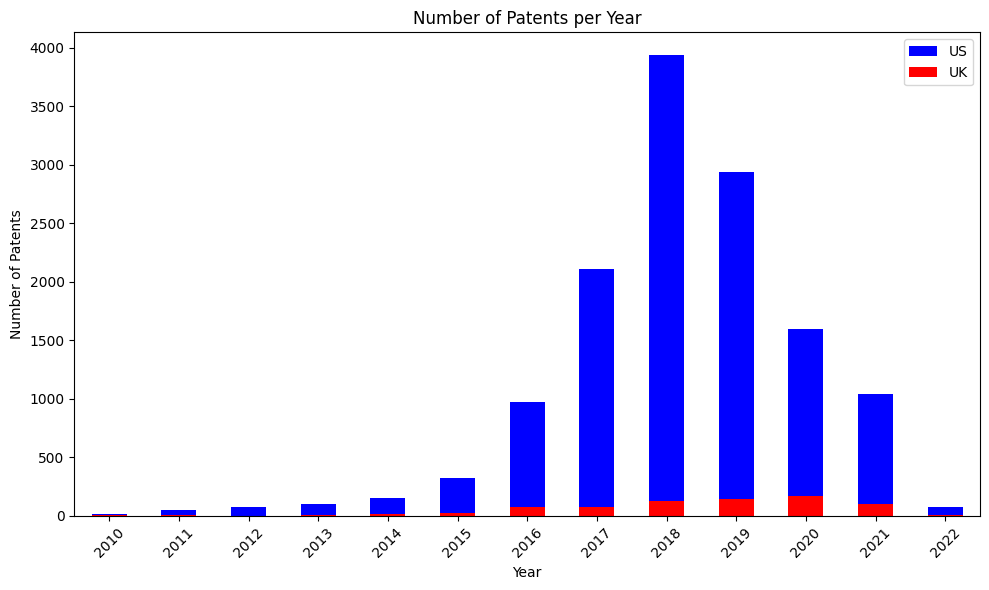

In [828]:
# Bar chart for number of patents per year
plt.figure(figsize=(10, 6))
us_patents_per_year = us_patents_per_month.groupby('filingYear')['number_of_patents'].sum()
uk_patents_per_year = uk_patents_per_month.groupby('filingYear')['number_of_patents'].sum()

us_patents_per_year.plot(kind='bar', color='blue')
uk_patents_per_year.plot(kind='bar', color='red')

plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.legend(['US', 'UK'])
plt.title('Number of Patents per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

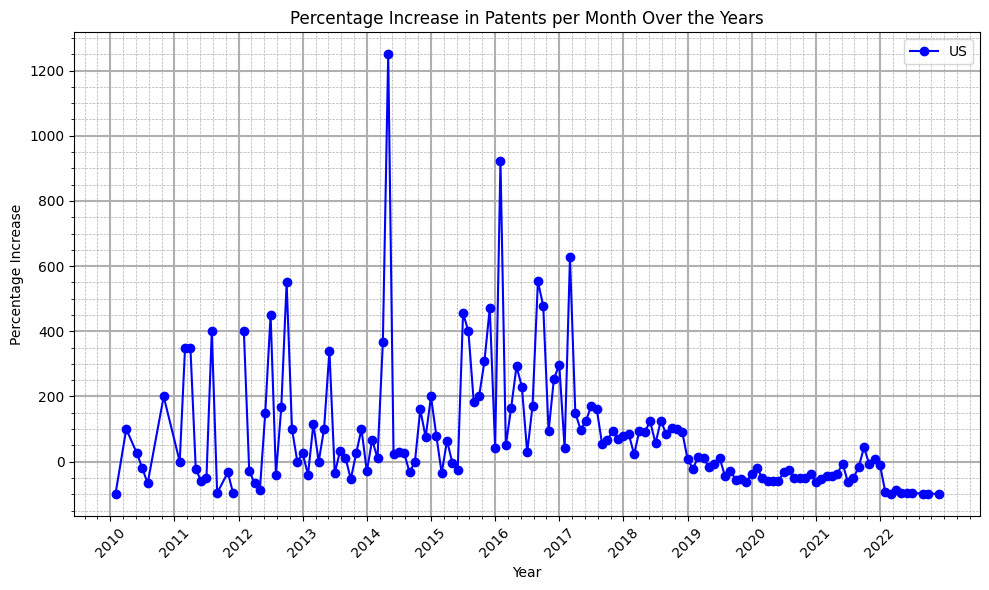

In [829]:
# Line chart for percentage increase over the years with NaN values skipped
plt.figure(figsize=(10, 6))
plt.plot(us_patents_per_month['filingYear'] + (us_patents_per_month['filingMonth'] - 1) / 12,
         us_patents_per_month['percentage_increase'], marker='o', linestyle='-', color='blue')
#plt.plot(uk_patents_per_month['filingYear'] + (uk_patents_per_month['filingMonth'] - 1) / 12,
#         uk_patents_per_month['percentage_increase'], marker='o', linestyle='-', color='red')

plt.xlabel('Year')
plt.ylabel('Percentage Increase')
plt.title('Percentage Increase in Patents per Month Over the Years')
plt.legend(['US', 'UK'])
plt.xticks(us_patents_per_month['filingYear'].unique(), rotation=45)
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.grid(True, which='major', linestyle='-', linewidth=1.5)
plt.tight_layout()
plt.show()


In [830]:

# Load and preprocess the data
us_patents_per_month_df_m = us_patents_per_month_df_m.drop(columns=['percentage_increase', 'number_of_citations'])
us_patents_per_month_df_m['filingMonthYear'] = pd.to_datetime(us_patents_per_month_df_m['filingMonthYear'], format="%d/%m/%Y")
us_patents_per_month_df_m.set_index('filingMonthYear', inplace=True)
us_patents_per_month_df_diff = us_patents_per_month_df_diff.asfreq('M')
print(us_patents_per_month_df_m)



                 number_of_patents
filingMonthYear                   
2010-02-01                       1
2010-04-01                       2
2010-06-01                       5
2010-07-01                       4
2010-08-01                       1
...                            ...
2022-06-01                       5
2022-07-01                       3
2022-09-01                       2
2022-10-01                       1
2022-12-01                       2

[146 rows x 1 columns]


In [831]:
us_patents_per_month_df_diff = us_patents_per_month_df_diff.asfreq('M')
print(us_patents_per_month_df_m)

                 number_of_patents
filingMonthYear                   
2010-02-01                       1
2010-04-01                       2
2010-06-01                       5
2010-07-01                       4
2010-08-01                       1
...                            ...
2022-06-01                       5
2022-07-01                       3
2022-09-01                       2
2022-10-01                       1
2022-12-01                       2

[146 rows x 1 columns]


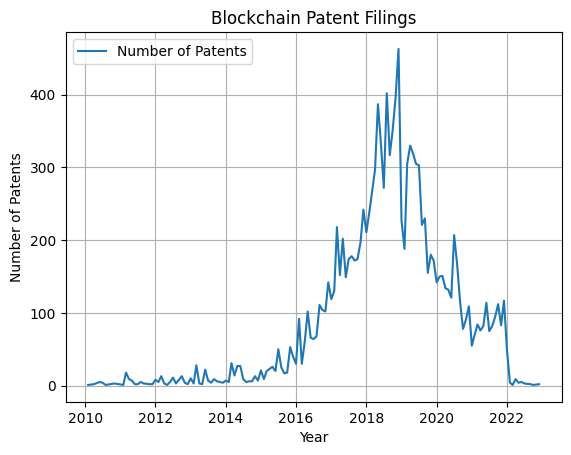

ADF Statistic: -1.2205453590073103
p-value: 0.6646957675237264


In [832]:
# Visualize the time series data
plt.plot(us_patents_per_month_df_m)
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Blockchain Patent Filings')
plt.legend(['Number of Patents','Percentage Change'])
#plt.xticks(patents_per_year_df['filingYear'], rotation=45)
plt.grid()
plt.show()

# Perform Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(us_patents_per_month_df_m['number_of_patents'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

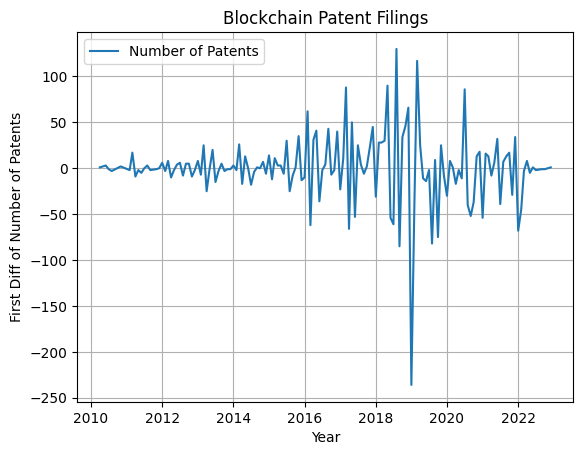

In [833]:
# Perform first differencing to make the data stationary
us_patents_per_month_df_diff = us_patents_per_month_df_m.diff().dropna()

# Visualize the time series data
plt.plot(us_patents_per_month_df_diff)
plt.xlabel('Year')
plt.ylabel('First Diff of Number of Patents')
plt.title('Blockchain Patent Filings')
plt.legend(['Number of Patents','Percentage Change'])
#plt.xticks(patents_per_year_df['filingYear'], rotation=45)
plt.grid()
plt.show()

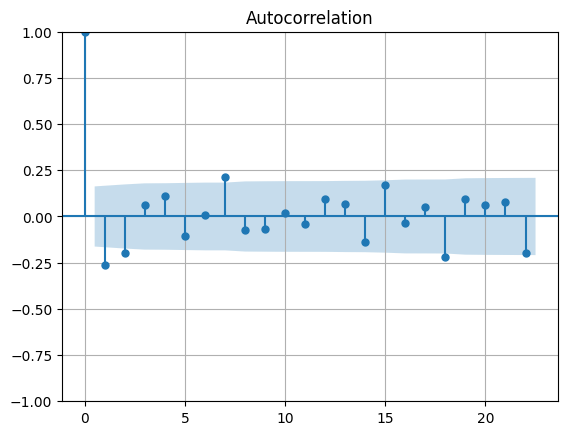

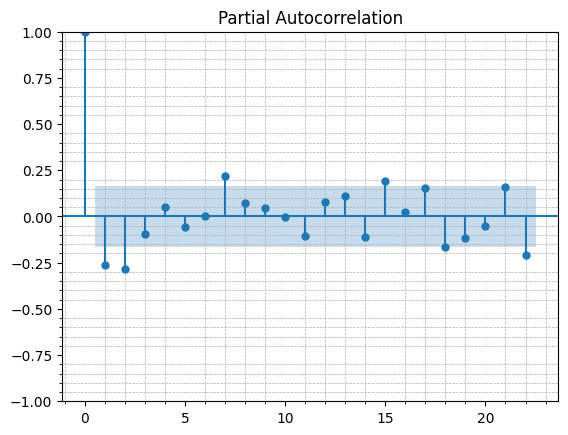

In [834]:
# Plot ACF and PACF plots
plot_acf(us_patents_per_month_df_diff['number_of_patents'])
plt.grid()
plot_pacf(us_patents_per_month_df_diff['number_of_patents'])  # Use a smaller number of lags
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.grid(True, which='major', linestyle='--', linewidth=0.7)
plt.grid()
plt.show()



### Based on PACF, we should start with an Auto Regressive Model with lags 1, 2, 7, 15, ....

### Get training and test sets

In [835]:
# Set the date index and resample to monthly frequency

us_patents_per_month_df_diff = us_patents_per_month_df_diff.asfreq('M')
print(us_patents_per_month_df_diff)
train_end = datetime(2021,12,1)
test_end = datetime(2022,12,1)

#train_data = patents_per_month_df_diff['number_of_patents']  # Select the target column
train_data = us_patents_per_month_df_diff[:train_end]
test_data = us_patents_per_month_df_diff[train_end + timedelta(days=1):test_end]



                 number_of_patents
filingMonthYear                   
2010-04-30                     NaN
2010-05-31                     NaN
2010-06-30                     NaN
2010-07-31                     NaN
2010-08-31                     NaN
...                            ...
2022-07-31                     NaN
2022-08-31                     NaN
2022-09-30                     NaN
2022-10-31                     NaN
2022-11-30                     NaN

[152 rows x 1 columns]


## Fit the AR Model

In [807]:
#create the model

model = ARIMA(train_data, order=(7,1,0))


c:\Users\Akande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Akande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Akande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [719]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)


Model Fitting Time: 0.17552947998046875


In [720]:
#summary of model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      number_of_patents   No. Observations:                  135
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -670.703
Date:                Mon, 21 Aug 2023   AIC                           1357.405
Time:                        23:25:04   BIC                           1380.588
Sample:                             0   HQIC                          1366.826
                                - 135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2985      0.069    -18.934      0.000      -1.433      -1.164
ar.L2         -1.4617      0.113    -12.909      0.000      -1.684      -1.240
ar.L3         -1.3781      0.156     -8.832      0.0